# Analysis of TRPO on Swimmer

## General setting:
* Policy mean: 64x64 tanh with biases
* Policy std: one logstd parameter for each action dimension
* Random seed: 0

In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def read_data(path):
    df = pd.read_csv(path + 'progress.csv')
    iterations = len(df)
    sigma_1 = []
    sigma_2 = []
    for i in range(iterations):
        weight = np.load(path + 'weights_' + str(i) + '.npy')
        sigma_1.append(np.exp(weight[-2]))
        sigma_2.append(np.exp(weight[-1]))
    df['Sigma_1'] = sigma_1
    df['Sigma_2'] = sigma_2
    return df

def plot_data(df, columns, bottom=-np.infty, top=np.infty):
    plt.close('all')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel('Iteration')
    x = range(len(df))
    for col in columns:
        y = np.clip(df[col], bottom, top)
        ax.plot(x, y, label=col)
    ax.legend()
    return fig

## 1. Unbiased per-decision importance weighting

In [211]:
path = '../results/trpo/mlp/30_3_0/unbiased/'
df_1 = read_data(path)


**Available data:**

In [212]:
list(df)

['entloss',
 'ev_tdlam_before',
 'Var_J',
 'optimgain',
 'Var_ret',
 'meankl',
 'surrgain',
 'EpisodesSoFar',
 'Reny_4',
 'entropy',
 'EpThisIter',
 'Step_size',
 'Our_bound',
 'Avg_iw',
 'Max_ret',
 'TimeElapsed',
 'DiscEpRewMean',
 'EpLenMean',
 'Var_iw',
 'J_hat',
 'Avg_ret',
 'TimestepsSoFar',
 'Max_iw',
 'EpRewMean',
 'Sigma_1',
 'Sigma_2']

### Actual performance of TRPO vs our bound

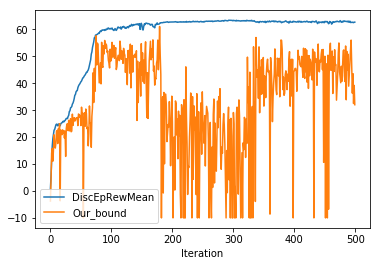

In [213]:
plot_data(df_1, ['DiscEpRewMean', 'Our_bound'], bottom=-10)

### Policy std

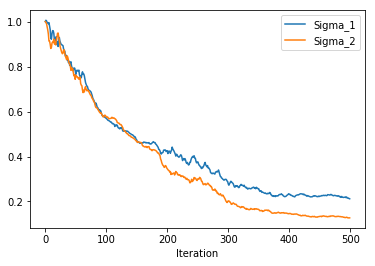

In [214]:
plot_data(df_1, ['Sigma_1', 'Sigma_2'])

### Importance weights variance vs Monte Carlo variance

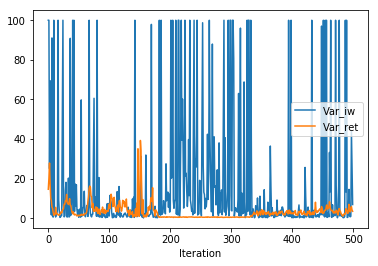

In [215]:
plot_data(df_1, ['Var_iw', 'Var_ret'], top=100)

### Importance weights moments

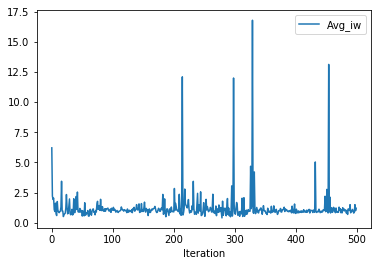

In [216]:
plot_data(df_1, ['Avg_iw'], top=100)

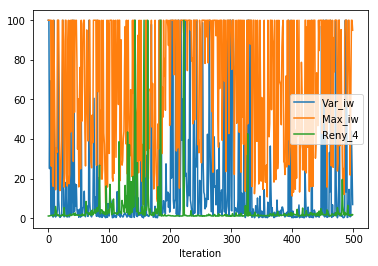

In [217]:
plot_data(df_1, ['Var_iw', 'Max_iw', 'Reny_4'], top=100)

## 2. Self-normalized per-decision importance weighting

In [218]:
path = '../results/trpo/mlp/30_3_0/self_normalized/'
df_2 = read_data(path)

### Actual performance of TRPO vs our bound

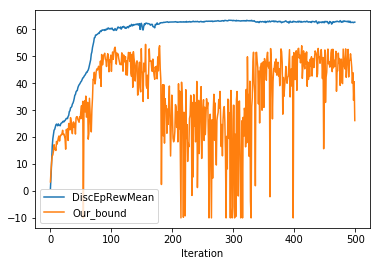

In [219]:
plot_data(df_2, ['DiscEpRewMean', 'Our_bound'], bottom=-10)

### Policy std

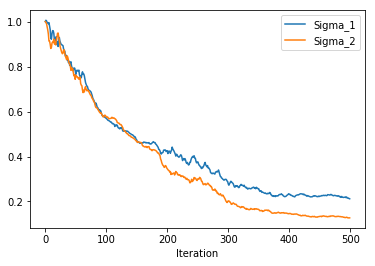

In [220]:
plot_data(df_2, ['Sigma_1', 'Sigma_2'])

### Importance weights variance vs Monte Carlo variance

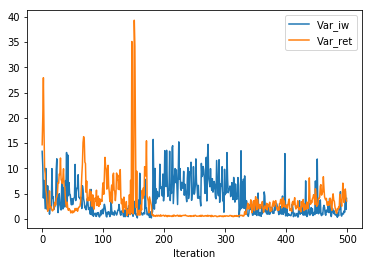

In [221]:
plot_data(df_2, ['Var_iw', 'Var_ret'])

### Importance weights moments

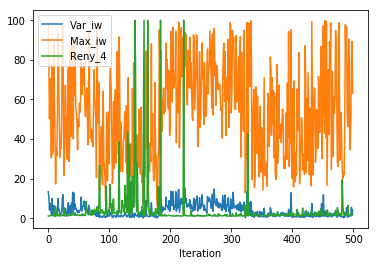

In [222]:
plot_data(df_2, ['Var_iw', 'Max_iw', 'Reny_4'], top=100)

## 2. Truncated (above at 10) per-decision importance weighting

In [223]:
path = '../results/trpo/mlp/30_3_0/truncated/'
df_3 = read_data(path)

### Actual performance of TRPO vs our bound

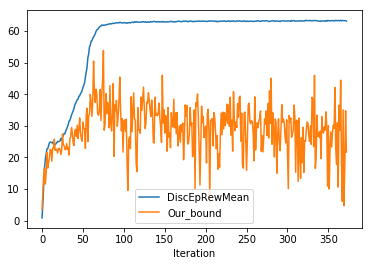

In [224]:
plot_data(df_3, ['DiscEpRewMean', 'Our_bound'], bottom=-10)

### Policy std

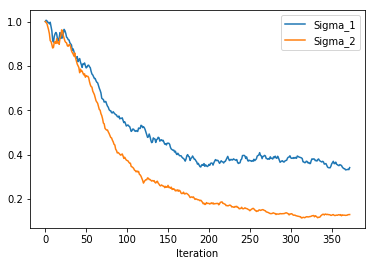

In [225]:
plot_data(df_3, ['Sigma_1', 'Sigma_2'])

### Importance weights variance vs Monte Carlo variance

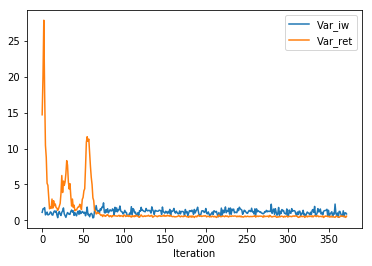

In [226]:
plot_data(df_3, ['Var_iw', 'Var_ret'])

### Importance weights moments

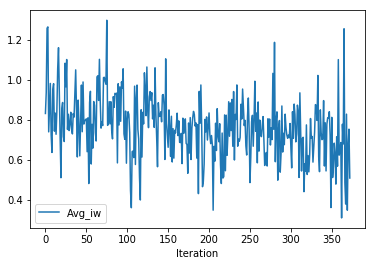

In [227]:
plot_data(df_3, ['Avg_iw'], top=100)

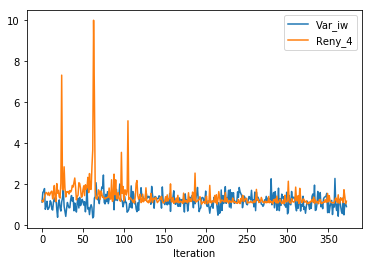

In [228]:
plot_data(df_3, ['Var_iw', 'Reny_4'], top=10)